In [1]:
import os
import re
import json
import socket
import subprocess
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession
from pyspark.sql import utils as pu
from pyspark.sql import functions as F
from pyspark.sql import types as pt

## Assignment #1 

This task rely on to 

In [2]:
print('user:', os.environ['JUPYTERHUB_SERVICE_PREFIX'])

def uiWebUrl(self):
    from urllib.parse import urlparse
    web_url = self._jsc.sc().uiWebUrl().get()
    port = urlparse(web_url).port
    return '{}proxy/{}/jobs/'.format(os.environ['JUPYTERHUB_SERVICE_PREFIX'], port)

SparkContext.uiWebUrl = property(uiWebUrl)

conf = SparkConf().set('spark.master', 'local[*]').set('spark.driver.memory', '4g').set("spark.executor.instances", "4")
sc = SparkContext(conf=conf)
spark = SparkSession(sc)
spark

user: /user/st095440/


## Songs 

The songs. Note that data is in unicode.

- song_id
- song_length: in ms
- genre_ids: genre category. Some songs have multiple genres and they are separated by |
- artist_name
- composer
- lyricist
- language


In [3]:
songs = spark.read.option("header", "True")\
    .csv("file:///home/jovyan/__DATA/big_data_2022/labs/kkbox-music-recommendation-challenge/songs.csv")

songs.limit(100).toPandas().head(10)

,song_id,song_length,genre_ids,artist_name,composer,lyricist,language
0,CXoTN1eb7AI+DntdU1vbcwGRV4SCIDxZu+YD8JP8r4E=,247640,465,張信哲 (Jeff Chang),董貞,何啟弘,3.0
1,o0kFgae9QtnYgRkVPqLJwa05zIhRlUjfF7O1tDw0ZDU=,197328,444,BLACKPINK,TEDDY| FUTURE BOUNCE| Bekuh BOOM,TEDDY,31.0
2,DwVvVurfpuz+XPuFvucclVQEyPqcpUkHR0ne1RQzPs0=,231781,465,SUPER JUNIOR,None,None,31.0
3,dKMBWoZyScdxSkihKG+Vf47nc18N9q4m58+b4e7dSSE=,273554,465,S.H.E,湯小康,徐世珍,3.0
4,W3bqWd3T+VeHFzHAUfARgW9AvVRaF4N5Yzm4Mr6Eo/o=,140329,726,貴族精選,Traditional,Traditional,52.0
5,kKJ2JNU5h8rphyW21ovC+RZU+yEHPM+3w85J37p7vEQ=,235520,864|857|850|843,貴族精選,Joe Hisaishi,Hayao Miyazaki,17.0
6,N9vbanw7BSMoUgdfJlgX1aZPE1XZg8OS1wf88AQEcMc=,226220,458,伍佰 & China Blue,Jonathan Lee,None,3.0
7,GsCpr618xfveHYJdo+E5SybrpR906tsjLMeKyrCNw8s=,276793,465,光良 (Michael Wong),光良,彭資閔,3.0
8,oTi7oINPX+rxoGp+3O6llSltQTl80jDqHoULfRoLcG4=,228623,465,林俊傑 (JJ Lin),JJ Lin,Wu Qing Feng,3.0
9,btcG03OHY3GNKWccPP0auvtSbhxog/kllIIOx5grE/k=,232629,352|1995,Kodaline,Stephen Garrigan| Mark Prendergast| Vincent Ma...,Stephen Garrigan| Mark Prendergast| Vincent Ma...,52.0


## "Train" data

Some data of users listen history 

- msno: user id
- song_id: song id
- source_system_tab: the name of the tab where the event was triggered. System tabs are used to categorize KKBOX mobile apps functions. For example, tab my library contains functions to manipulate the local storage, and tab search contains functions relating to search.
- source_screen_name: name of the layout a user sees.
- source_type: an entry point a user first plays music on mobile apps. An entry point could be album, online-playlist, song .. etc.
- target: this is the target variable. target=1 means there are recurring listening event(s) triggered within a month after the user’s very first observable listening event, target=0 otherwise .


In [4]:
listen_history = spark.read.option("header", "True")\
    .csv("file:///home/jovyan/__DATA/big_data_2022/labs/kkbox-music-recommendation-challenge/train.csv")

listen_history.show()

+--------------------+--------------------+-----------------+-------------------+-------------------+------+
|                msno|             song_id|source_system_tab| source_screen_name|        source_type|target|
+--------------------+--------------------+-----------------+-------------------+-------------------+------+
|FGtllVqz18RPiwJj/...|BBzumQNXUHKdEBOB7...|          explore|            Explore|    online-playlist|     1|
|Xumu+NIjS6QYVxDS4...|bhp/MpSNoqoxOIB+/...|       my library|Local playlist more|     local-playlist|     1|
|Xumu+NIjS6QYVxDS4...|JNWfrrC7zNN7BdMps...|       my library|Local playlist more|     local-playlist|     1|
|Xumu+NIjS6QYVxDS4...|2A87tzfnJTSWqD7gI...|       my library|Local playlist more|     local-playlist|     1|
|FGtllVqz18RPiwJj/...|3qm6XTZ6MOCU11x8F...|          explore|            Explore|    online-playlist|     1|
|FGtllVqz18RPiwJj/...|3Hg5kugV1S0wzEVLA...|          explore|            Explore|    online-playlist|     1|
|Xumu+NIjS6QYVxDS4.

## Assignment:

PREFER DATA FRAME API(!)

Vision of result:
- self-sufficient jupyter notebook
- not only the code but n
- published on github 
- link to your github attached here https://docs.google.com/spreadsheets/d/1F8ScpCCiBaxiyZqDd09jn6t25pykiK8oauJbRuuA8Q4/edit?usp=sharing


Task 1: 
- Find out top-20 of most popular artist's in terms of: raw listens, unique users listens;

Task 2: 
- find out top-3 languages by num of raw listens
- build histogram of songs length by language / genre. What is the longest genre? What is more valuable in terms of length: language or genre? 

Deadlines:
- soft 17.05
- hard 24.05

In [5]:
songs = spark.read.option("header", "True")\
    .csv("file:///home/jovyan/__DATA/big_data_2022/labs/kkbox-music-recommendation-challenge/songs.csv")

songs.limit(100).toPandas().head(10)

,song_id,song_length,genre_ids,artist_name,composer,lyricist,language
0,CXoTN1eb7AI+DntdU1vbcwGRV4SCIDxZu+YD8JP8r4E=,247640,465,張信哲 (Jeff Chang),董貞,何啟弘,3.0
1,o0kFgae9QtnYgRkVPqLJwa05zIhRlUjfF7O1tDw0ZDU=,197328,444,BLACKPINK,TEDDY| FUTURE BOUNCE| Bekuh BOOM,TEDDY,31.0
2,DwVvVurfpuz+XPuFvucclVQEyPqcpUkHR0ne1RQzPs0=,231781,465,SUPER JUNIOR,None,None,31.0
3,dKMBWoZyScdxSkihKG+Vf47nc18N9q4m58+b4e7dSSE=,273554,465,S.H.E,湯小康,徐世珍,3.0
4,W3bqWd3T+VeHFzHAUfARgW9AvVRaF4N5Yzm4Mr6Eo/o=,140329,726,貴族精選,Traditional,Traditional,52.0
5,kKJ2JNU5h8rphyW21ovC+RZU+yEHPM+3w85J37p7vEQ=,235520,864|857|850|843,貴族精選,Joe Hisaishi,Hayao Miyazaki,17.0
6,N9vbanw7BSMoUgdfJlgX1aZPE1XZg8OS1wf88AQEcMc=,226220,458,伍佰 & China Blue,Jonathan Lee,None,3.0
7,GsCpr618xfveHYJdo+E5SybrpR906tsjLMeKyrCNw8s=,276793,465,光良 (Michael Wong),光良,彭資閔,3.0
8,oTi7oINPX+rxoGp+3O6llSltQTl80jDqHoULfRoLcG4=,228623,465,林俊傑 (JJ Lin),JJ Lin,Wu Qing Feng,3.0
9,btcG03OHY3GNKWccPP0auvtSbhxog/kllIIOx5grE/k=,232629,352|1995,Kodaline,Stephen Garrigan| Mark Prendergast| Vincent Ma...,Stephen Garrigan| Mark Prendergast| Vincent Ma...,52.0


In [6]:
listen_history = spark.read.option("header", "True")\
    .csv("file:///home/jovyan/__DATA/big_data_2022/labs/kkbox-music-recommendation-challenge/train.csv")

listen_history.limit(100).toPandas().head(10)

,msno,song_id,source_system_tab,source_screen_name,source_type,target
0,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,BBzumQNXUHKdEBOB7mAJuzok+IJA1c2Ryg/yzTF6tik=,explore,Explore,online-playlist,1
1,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,bhp/MpSNoqoxOIB+/l8WPqu6jldth4DIpCm3ayXnJqM=,my library,Local playlist more,local-playlist,1
2,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,JNWfrrC7zNN7BdMpsISKa4Mw+xVJYNnxXh3/Epw7QgY=,my library,Local playlist more,local-playlist,1
3,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,2A87tzfnJTSWqD7gIZHisolhe4DMdzkbd6LzO1KHjNs=,my library,Local playlist more,local-playlist,1
4,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,3qm6XTZ6MOCU11x8FIVbAGH5l5uMkT3/ZalWG1oo2Gc=,explore,Explore,online-playlist,1
5,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,3Hg5kugV1S0wzEVLAEfqjIV5UHzb7bCrdBRQlGygLvU=,explore,Explore,online-playlist,1
6,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,VkILU0H1h3NMmk9MQrXouNudGk5n8Ls5cqRRuBxeTh4=,my library,Local playlist more,local-playlist,1
7,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,bPIvRTzfHxH5LgHrStll+tYwSQNVV8PySgA3M1PfTgc=,explore,Explore,online-playlist,1
8,uHqAtShXTRXju5GE8ri3ITsVFepPf8jUoCF7ffNOuqE=,/bU6IRSK+YNlNbaTkxo7bhsb2EDLPrnksdX3ggcZNhI=,my library,Local playlist more,local-library,1
9,uHqAtShXTRXju5GE8ri3ITsVFepPf8jUoCF7ffNOuqE=,EbI7xoNxI+3QSsiHxL13zBdgHIJOwa3srHd7cDcnJ0g=,my library,Local playlist more,local-library,1


In [7]:
members = spark.read.option("header", "True")\
    .csv("file:///home/jovyan/__DATA/big_data_2022/labs/kkbox-music-recommendation-challenge/members.csv")

members.limit(100).toPandas().head(10)

,msno,city,bd,gender,registered_via,registration_init_time,expiration_date
0,XQxgAYj3klVKjR3oxPPXYYFp4soD4TuBghkhMTD4oTw=,1,0,None,7,20110820,20170920
1,UizsfmJb9mV54qE9hCYyU07Va97c0lCRLEQX3ae+ztM=,1,0,None,7,20150628,20170622
2,D8nEhsIOBSoE6VthTaqDX8U6lqjJ7dLdr72mOyLya2A=,1,0,None,4,20160411,20170712
3,mCuD+tZ1hERA/o5GPqk38e041J8ZsBaLcu7nGoIIvhI=,1,0,None,9,20150906,20150907
4,q4HRBfVSssAFS9iRfxWrohxuk9kCYMKjHOEagUMV6rQ=,1,0,None,4,20170126,20170613
5,zgPOEyUn5a/Fvuzb3m69ajzxjkbblVtObglW89FzLdo=,13,43,female,9,20120703,20171006
6,Sw9AT8QoR4wWiNUqHZUH6g5ahzGUx4lo1g+Y3xE2f2M=,1,0,None,4,20160326,20160329
7,pg6bT2XZkSP1TDBy4qn3HBPY/HffKQ/bg8WIISQYBSY=,1,0,None,7,20160130,20170930
8,kfk1AdTNH2dNqF5LzIs4e0vwGPejw2jrnFjJlcYnEgk=,1,0,None,7,20110111,20170930
9,tscijwx4dbEp0NXGl+iFtHJ8zrj+TkcMrduOQk9t+gE=,1,0,None,7,20160217,20170613


## Task 1


### Top-20 of most popular artist's in terms of raw listens using the approach from lecrure 4
First of all, we need to join two dataset on `"song_id"` using `join`.
Secondly, we need to group our data on `"artist_name"`, then find the sum of `"raw listeners"`.
Finally, we sort it and find TOP-20

In [8]:
joined = listen_history.join(songs, ["song_id"], 'inner')

joined.groupBy("artist_name")\
.agg(F.count(F.col("msno")).alias("raw listens")).orderBy(F.col("raw listens").desc())\
.limit(100).toPandas().head(20)

,artist_name,raw listens
0,Various Artists,303617
1,周杰倫 (Jay Chou),186776
2,五月天 (Mayday),182088
3,林俊傑 (JJ Lin),115325
4,田馥甄 (Hebe),104946
5,aMEI (張惠妹),82799
6,陳奕迅 (Eason Chan),76035
7,玖壹壹,70445
8,G.E.M.鄧紫棋,67297
9,BIGBANG,61927


### Using the approach from the previous task, we will find Top-20 "unique users listens"

In [9]:
joined.groupBy("artist_name")\
.agg(F.countDistinct(F.col("msno")).alias("unique users listens")).orderBy(F.col("unique users listens").desc())\
.limit(100).toPandas().head(20)

,artist_name,unique users listens
0,Various Artists,22256
1,田馥甄 (Hebe),18771
2,周杰倫 (Jay Chou),18727
3,五月天 (Mayday),18183
4,林俊傑 (JJ Lin),17160
5,陳奕迅 (Eason Chan),16290
6,G.E.M.鄧紫棋,16064
7,Eric 周興哲,15672
8,謝和弦 (R-chord),15313
9,aMEI (張惠妹),15169


## Task 2
### Find out top-3 languages by num of raw listens

In [10]:
joined.groupBy("language")\
.agg(F.count(F.col("msno")).alias("raw listens")).orderBy(F.col("raw listens").desc())\
.limit(100).toPandas().head(3)

,language,raw listens
0,3.0,4044643
1,52.0,1864788
2,31.0,656623


### Build histogram of songs length by language / genre. What is the longest genre? What is more valuable in terms of length: language or genre?

In [11]:
songs_lang_len = songs.groupby(F.col("language"))\
.agg(F.sum("song_length").alias("song_length_sum")).orderBy(F.col("song_length_sum").desc())\
.limit(100).toPandas()

In [12]:
songs_lang_len.head(10)

,language,song_length_sum
0,52.0,3.134235e+11
1,-1.0,1.764514e+11
2,3.0,2.594856e+10
3,17.0,2.316844e+10
4,24.0,9.963970e+09
5,31.0,8.582794e+09
6,10.0,3.770904e+09
7,45.0,3.480345e+09
8,59.0,1.811680e+09
9,38.0,5.746941e+08


In [13]:
#convert in ms into thousands of hour
songs_lang_len['song_length_sum_in_th_hours'] = songs_lang_len['song_length_sum']/60/60/60/1000

In [14]:
songs_lang_len.head(10)

,language,song_length_sum,song_length_sum_in_th_hours
0,52.0,3.134235e+11,1451.034816
1,-1.0,1.764514e+11,816.904645
2,3.0,2.594856e+10,120.132206
3,17.0,2.316844e+10,107.261303
4,24.0,9.963970e+09,46.129490
5,31.0,8.582794e+09,39.735159
6,10.0,3.770904e+09,17.457890
7,45.0,3.480345e+09,16.112709
8,59.0,1.811680e+09,8.387407
9,38.0,5.746941e+08,2.660621


<AxesSubplot:xlabel='language', ylabel='song_length_sum_in_th_hours'>

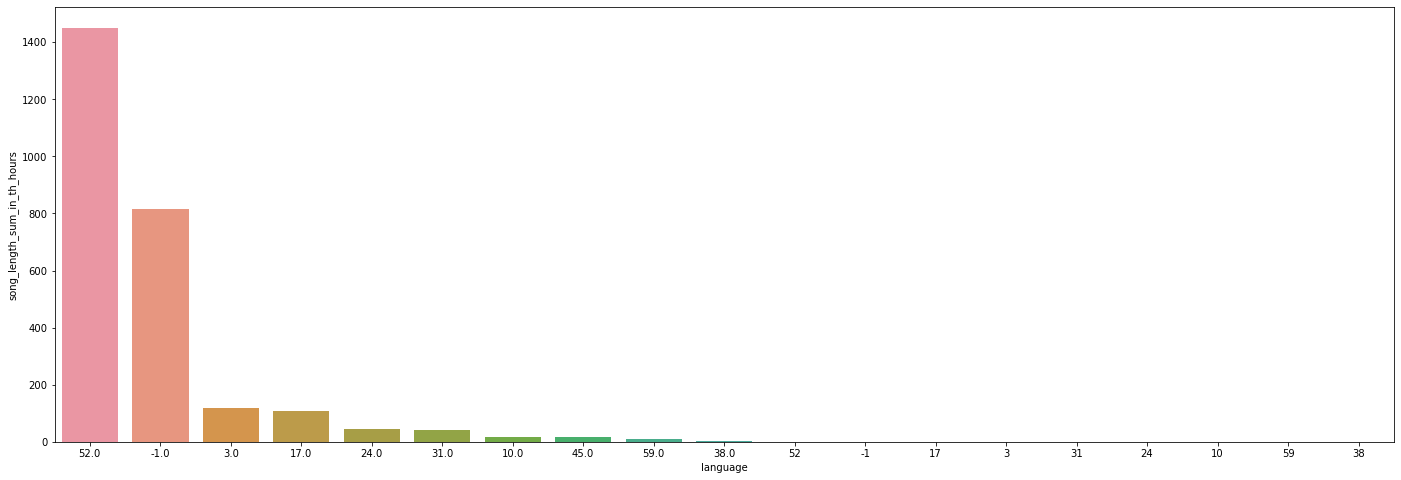

In [15]:
fig, ax = plt.subplots(figsize=(24, 8))
sns.barplot(x='language', y='song_length_sum_in_th_hours', data=songs_lang_len.head(20), ax=ax)

In [16]:
genre_song_length = songs.select("genre_ids", "song_length")\
.groupby(F.col("genre_ids"))\
.agg(F.sum("song_length").alias("song_length_sum"))\
.toPandas()

In [17]:
genre_song_length.genre_ids.describe()

count     1046
unique    1046
top        444
freq         1
Name: genre_ids, dtype: object

In [18]:
genre_song_length.head(20)

,genre_ids,song_length_sum
0,829,2.644641e+09
1,691,3.710705e+09
2,1572,3.748923e+08
3,1152|465|1180,5.705852e+06
4,1152|2022,1.396196e+07
5,1944|310,2.118175e+07
6,423|1047,2.223643e+06
7,2022|430,1.250166e+07
8,1633|1955,6.148940e+05
9,451,3.193254e+09


In [19]:
#convert in ms into thousands of hour
genre_song_length['genre_song_length_in_th_hours'] = genre_song_length['song_length_sum']/60/60/60/1000

<AxesSubplot:xlabel='genre_ids', ylabel='genre_song_length_in_th_hours'>

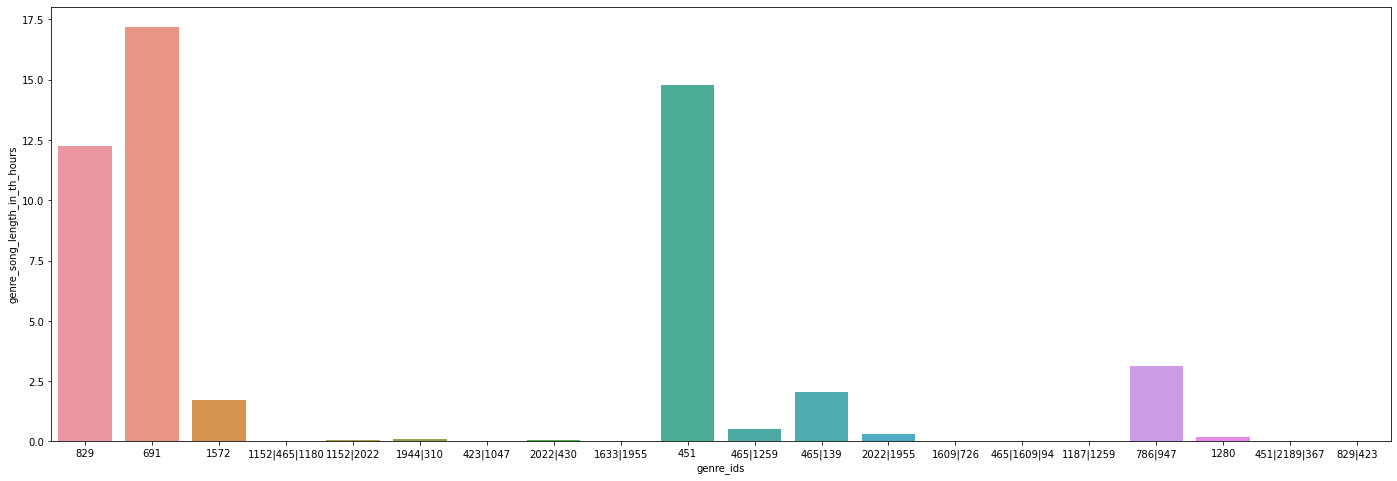

In [20]:
fig, ax = plt.subplots(figsize=(24, 8))
plt.ticklabel_format(style='plain', axis='y')
sns.barplot(x='genre_ids', y='genre_song_length_in_th_hours', data=genre_song_length.head(20), ax=ax)

## Answers
What is the longest genre? 829
What is more valuable in terms of length: language or genre? from my standpoint, Language is more important, as genres has more than 1000 unique values, and can be combined in different ways. In turn, language is more 'stable feature'